<a href="https://colab.research.google.com/github/careldelvine/CapstoneProject-SegarBox/blob/main/Recommendation%20System%20-%20Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 5.8 MB 46.8 MB/s 
     |████████████████████████████████| 1.6 MB 44.1 MB/s 
     |████████████████████████████████| 438 kB 72.2 MB/s 
     |████████████████████████████████| 4.3 MB 31.1 MB/s 
     |████████████████████████████████| 11.2 MB 12.8 MB/s 


In [2]:
p = os.path.abspath('./Dataset')
base = os.path.abspath('.')
print(p)

total_data = 100000
train_data = int(total_data * 0.8)
test_data = int(total_data - train_data)

/content/Dataset


In [3]:
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [4]:
#Loading the dataset

url = 'https://raw.githubusercontent.com/SegarBox/Recommendation-System/main/Dataset/ratings_Beauty.csv'
train = pd.read_csv(url)
train = train.dropna()
train.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [5]:
train.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp      int64
dtype: object

In [6]:
train.UserID = train.UserId.astype(str)
train.Rating = train.Rating.astype(int)
train.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5,1369699200
1,A3JM6GV9MNOF9X,0558925278,3,1355443200


In [7]:
train.dtypes

UserId       object
ProductId    object
Rating        int64
Timestamp     int64
dtype: object

In [8]:
ratings = tf.data.Dataset.from_tensor_slices({
    "user_id": train.UserID.tolist(),
    "Product_id": train.ProductId.tolist(),
    "rating": train.Rating.tolist(),
    "timestamp": train.Timestamp.tolist()
})

In [9]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'Product_id': b'0205616461',
 'rating': 5,
 'timestamp': 1369699200,
 'user_id': b'A39HTATAQ9V7YF'}


In [10]:
list(ratings.take(2).as_numpy_iterator())

[{'Product_id': b'0205616461',
  'rating': 5,
  'timestamp': 1369699200,
  'user_id': b'A39HTATAQ9V7YF'},
 {'Product_id': b'0558925278',
  'rating': 3,
  'timestamp': 1355443200,
  'user_id': b'A3JM6GV9MNOF9X'}]

In [11]:
ratings = ratings.map(lambda x: {
    "Product_id": x["Product_id"],
    "user_id": x["user_id"],
})

In [12]:
list(ratings.take(2).as_numpy_iterator())

[{'Product_id': b'0205616461', 'user_id': b'A39HTATAQ9V7YF'},
 {'Product_id': b'0558925278', 'user_id': b'A3JM6GV9MNOF9X'}]

In [13]:
products = tf.data.Dataset.from_tensor_slices({
    "Product_id": train.ProductId.tolist()
})

In [14]:
list(products.take(2).as_numpy_iterator())

[{'Product_id': b'0205616461'}, {'Product_id': b'0558925278'}]

In [15]:
products = products.map(lambda x: x["Product_id"])
list(products.take(2).as_numpy_iterator())

products = products.unique()
list(products.take(2).as_numpy_iterator())

[b'0205616461', b'0558925278']

In [16]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(total_data, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_data)
test = shuffled.skip(train_data).take(test_data)

user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
product_ids = products.batch(1_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_product_ids = np.unique(np.concatenate(list(product_ids)))

unique_product_ids[:10]

len(unique_user_ids), len(unique_product_ids)

embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

products_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_product_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_product_ids) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=products.batch(128).map(products_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [17]:
class ProductsModel(tfrs.Model):

  def __init__(self, user_model, products_model):
    super().__init__()
    self.products_model: tf.keras.Model = products_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the product features and pass them into the product model,
    # getting embeddings back.
    positive_products_embeddings = self.products_model(features["Product_id"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_products_embeddings)

In [18]:
class NoBaseClassProductsModel(tf.keras.Model):

  def __init__(self, user_model, products_model):
    super().__init__()
    self.products_model: tf.keras.Model = products_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Set up a gradient tape to record gradients.
    with tf.GradientTape() as tape:

      # Loss computation.
      user_embeddings = self.user_model(features["user_id"])
      positive_product_embeddings = self.products_model(features["Product_id"])
      loss = self.task(user_embeddings, positive_products_embeddings)

      # Handle regularization losses as well.
      regularization_loss = sum(self.losses)

      total_loss = loss + regularization_loss

    gradients = tape.gradient(total_loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

  def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    # Loss computation.
    user_embeddings = self.user_model(features["user_id"])
    positive_products_embeddings = self.products_model(features["Product_id"])
    loss = self.task(user_embeddings, positive_products_embeddings)

    # Handle regularization losses as well.
    regularization_loss = sum(self.losses)

    total_loss = loss + regularization_loss

    metrics = {metric.name: metric.result() for metric in self.metrics}
    metrics["loss"] = loss
    metrics["regularization_loss"] = regularization_loss
    metrics["total_loss"] = total_loss

    return metrics

In [19]:
model = ProductsModel(user_model, products_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(total_data).batch(8192).cache()
cached_test = test.batch(4096).cache()

history_train = model.fit(cached_train, validation_data=cached_test, epochs=10)

model.evaluate(cached_test, return_dict=True)

Epoch 1/10
10/10 [==============================] - 124s 12s/step - factorized_top_k/top_1_categorical_accuracy: 7.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0107 - factorized_top_k/top_10_categorical_accuracy: 0.0194 - factorized_top_k/top_50_categorical_accuracy: 0.0572 - factorized_top_k/top_100_categorical_accuracy: 0.0818 - loss: 70367.2379 - regularization_loss: 0.0000e+00 - total_loss: 70367.2379 - val_factorized_top_k/top_1_categorical_accuracy: 0.0034 - val_factorized_top_k/top_5_categorical_accuracy: 0.0167 - val_factorized_top_k/top_10_categorical_accuracy: 0.0294 - val_factorized_top_k/top_50_categorical_accuracy: 0.0807 - val_factorized_top_k/top_100_categorical_accuracy: 0.1135 - val_loss: 29625.1328 - val_regularization_loss: 0.0000e+00 - val_total_loss: 29625.1328
Epoch 2/10
10/10 [==============================] - 79s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0273 - factorized_top_k/top_5_categorical_accuracy: 0.3469 - factorized_top_k/top

{'factorized_top_k/top_100_categorical_accuracy': 0.06615000218153,
 'factorized_top_k/top_10_categorical_accuracy': 0.008799999952316284,
 'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_50_categorical_accuracy': 0.03525000065565109,
 'factorized_top_k/top_5_categorical_accuracy': 0.0044999998062849045,
 'loss': 31137.802734375,
 'regularization_loss': 0,
 'total_loss': 31137.802734375}

In [20]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends products out of the entire products dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((products.batch(100), products.batch(100).map(model.products_model)))
)

In [21]:
# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'B00023DIAY' b'B0000530O9' b'B0002UEDWE']


In [22]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(base, "model")

In [23]:
  # Save the index.
  tf.saved_model.save(index, path)

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted product titles back.
  scores, titles = loaded(["A39HTATAQ9V7YF"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


Recommendations: [b'B00006IQ95' b'B0002IVS9M' b'B0000ZHGZ2']


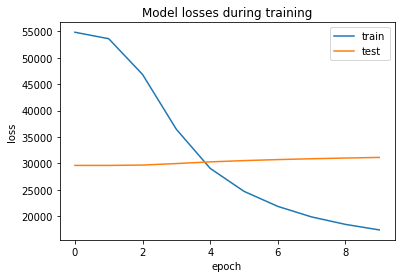

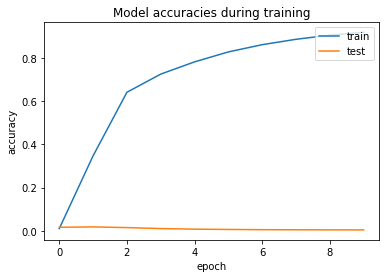

In [24]:
# print(history)
import matplotlib.pyplot as plt

plt.plot(history_train.history["loss"])
plt.plot(history_train.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

plt.plot(history_train.history["factorized_top_k/top_5_categorical_accuracy"])
plt.plot(history_train.history["val_factorized_top_k/top_5_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()
